## Load data and set db

In [1]:
%matplotlib inline
import matplotlib.ticker as mtick
from domestic_journals import DB_joinJournals
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
idx = pd.IndexSlice
from scipy.stats.mstats import gmean
import statsmodels.api as sm
from statsmodels.formula.api import ols

glob = pd.read_csv('data/index.csv').set_index(['country_code','field_code','method_code','period'])['value']
cntrs = pd.read_excel('../external_data/dfc.xlsx',index_col='country_code').drop_duplicates(keep='first')
usedIndicators = ['euclid','cosine','GiniSimpson','top3','instTOP3','shareEnglish','localShare']
db = DB_joinJournals('sqlite:///c:\\Users\\OP3202\\Documents\\Git\\GlobalizationPaper\\db\\180802_1611_AllJournals_ArReCp_2001_2017.sqlite')

fieldnames = {
    'top_Life':'Life sciences',
    'top_Health':'Health sciences',
    'top_Social':'Social sciences',
    'top_Physical':'Physical sciences',
}

ccodes = [col for col in glob.index.get_level_values('country_code').unique() if not col.startswith('_')]
flds_narrow = [col for col in glob.index.get_level_values('field_code').unique() if col.startswith('bot')]
flds_broad = [col for col in glob.index.get_level_values('field_code').unique() if col.startswith('top') or col == 'All']

## Introduction: 
### Domestic journals plot

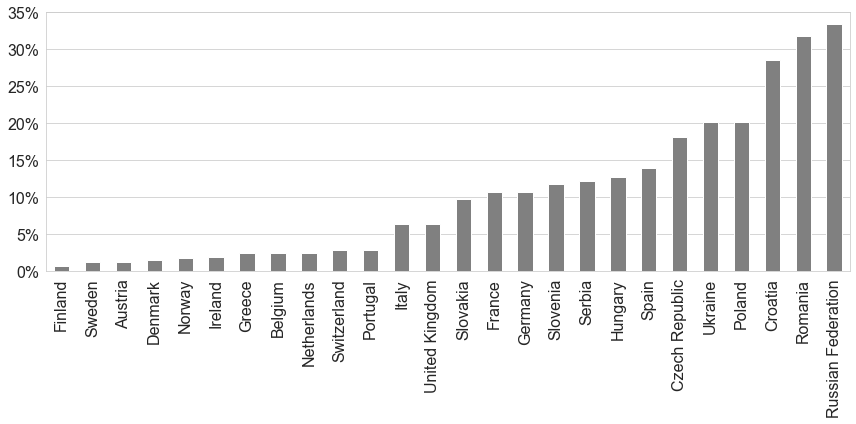

In [4]:
if False:
    from domestic_journals import calcDomesticJournalsEuropePlot
    locales = calcDomesticJournalsEuropePlot()
    ax = locales.localShare.plot(kind='bar',color='gray',figsize=(12,6),fontsize=16)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
    ax.xaxis.grid(False)
    ax.set_xlabel('')
    plt.tight_layout()
    plt.savefig('figs/fig1.png',figsize=(12,6))

## Data
### Average growth of documents in the database 

In [5]:
totyr = pd.read_sql_query('''
SELECT 
    p.name as year,
    sum(Articles) as Documents
FROM totalArticles ta
inner join periods p on ta.PeriodID = p.ID
where year >= 2005
group by year
''',con=db,index_col='year')
gm = gmean(1+totyr.pct_change().Documents.dropna())
totyr.Documents.iloc[0]*(gm)**12
print('Total documents: {}\nAverage growth: {}'.format(int(totyr.sum()),float(gm-1)))
totyr

Total documents: 22555542
Average growth: 0.04069087173672892


,Documents
year,
2005,1293436
2006,1371733
2007,1436340
2008,1500705
2009,1578731
2010,1631125
2011,1749111
2012,1836041
2013,1938184


## Results
### Number of calculated countries in 2017 by discipline

In [6]:
glob.loc[idx[ccodes,:,'euclid',2017]].reset_index().groupby('field_code').apply(lambda x: len(x.country_code.unique()))

field_code
All                                         171
bot_AgriculturalAndBiological               132
bot_ArtsHumanities                           76
bot_BiochemistryGeneticsMolecularBiology    108
bot_BusinessManagementAccounting             78
bot_ChemicalEngineering                      77
bot_Chemistry                                96
bot_ComputerScience                          88
bot_DecisionSciences                         55
bot_Dentistry                                41
bot_EarthPlanetarySciences                   92
bot_EconomicsEconometricsFinance             73
bot_Energy                                   73
bot_Engineering                             102
bot_EnvironmentalScience                    111
bot_General                                   9
bot_HealthProfessions                        50
bot_ImmunologyMicrobiology                   90
bot_Materials                                93
bot_Mathematics                              91
bot_Medicine                 

## Number of disciplines assigned to documents

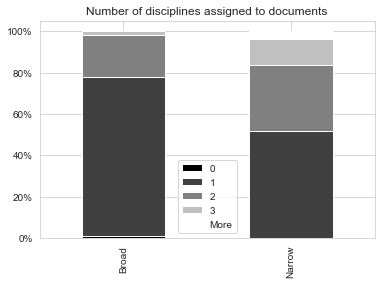

In [7]:
fieldnumber = pd.read_sql_query('''
select 
    ie.broadFieldsNum as broadFieldsNumber,
    ie.narrowFieldsNum as narrowFieldsNumber,
    Sum(Articles) as Documents from totalArticles ta 
inner join 
    (select 
        *,
        (top_Life + top_Social + top_Physical + top_Health) as broadFieldsNum,
        (bot_General + bot_AgriculturalAndBiological + bot_ArtsHumanities +
        bot_BiochemistryGeneticsMolecularBiology + bot_BusinessManagementAccounting + 
        bot_ChemicalEngineering + bot_Chemistry + bot_ComputerScience + 
        bot_DecisionSciences + bot_EarthPlanetarySciences + bot_EconomicsEconometricsFinance +
        bot_Energy + bot_Engineering + bot_EnvironmentalScience + bot_ImmunologyMicrobiology +
        bot_Materials + bot_Mathematics + bot_Medicine + bot_Neuroscience + bot_Nursing + 
        bot_PharmacologyToxicologyPharmaceutics + bot_PhysicsAstronomy + bot_Psychology + 
        bot_SocialSciences + bot_Veterinary + bot_Dentistry + bot_HealthProfessions) as narrowFieldsNum
    from issns i
    ) ie
    ON ie.ID = ta.ISSNID
    group by ie.broadFieldsNum,
    ie.narrowFieldsNum
''',con=db)
fieldshares = pd.DataFrame({
    'Broad':fieldnumber.groupby('broadFieldsNumber').Documents.sum()/fieldnumber.groupby('broadFieldsNumber').Documents.sum().sum(),
    'Narrow':fieldnumber.groupby('narrowFieldsNumber').Documents.sum()/fieldnumber.groupby('narrowFieldsNumber').Documents.sum().sum()
})
fieldshares.loc['More',:]=fieldshares.loc[4:,:].sum()

fieldshares = fieldshares.loc[[0,1,2,3,'More'],:]*100
ax = fieldshares.T.plot.bar(title='Number of disciplines assigned to documents',stacked=True,cmap='gray')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

### ANOVA - countries,disciplines,time

In [8]:
# Calculating effect size
def anova_table(df,formula):
    model  = ols(formula, df).fit()
    aov = sm.stats.anova_lm(model, typ=2)
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov,model

d = {}

formula = 'value ~ C(country_code) + \
                   C(field_code) + \
                   C(period)'# + \
                #   C(country_code)*C(field_code)'# + \
                #    C(country_code)*C(period) + \
                #    C(field_code)*C(period) + \
                #    C(field_code)*C(period)*C(country_code)'
for method in tqdm(usedIndicators):
    df_narrow = glob.loc[idx[ccodes,flds_narrow,method,:]].to_frame().reset_index()
    anova_narrow, model_narrow = anova_table(df_narrow,formula)
    tbl_narrow = anova_narrow['omega_sq']
    tbl_narrow['r_squared'] = model_narrow.rsquared
    d[('narrow',method)] = tbl_narrow
    #d[('narrow','omega_sq',method)] = anova_table(df_narrow,formula)['omega_sq'].sum()
    #d[('narrow','r_sq',method)] = ols(formula,df_narrow).fit().rsquared

    df_broad = glob.loc[idx[ccodes,flds_broad,method,:]].to_frame().reset_index()
    anova_broad, model_broad = anova_table(df_broad,formula)
    tbl_broad = anova_broad['omega_sq']
    tbl_broad['r_squared'] = model_broad.rsquared
    d[('broad',method)] = tbl_broad

#anova_cntr_fld_time = pd.Series(d).unstack()#.stack(0).reorder_levels((1,0)).sort_index()
anova_cntr_fld_time = pd.DataFrame(d).stack(0).reorder_levels((1,0)).sort_index()

anova_cntr_fld_time

100%|██████████| 7/7 [00:50<00:00,  7.89s/it]


GiniSimpson    cosine    euclid  instTOP3  localShare  \
broad  C(country_code)     0.554021  0.674688  0.575939  0.638360    0.373066   
       C(field_code)       0.135900  0.040550  0.109370  0.039870    0.233713   
       C(period)           0.026477  0.002562  0.002047  0.008985    0.042285   
       r_squared           0.722761  0.721544  0.691047  0.691651    0.659132   
narrow C(country_code)     0.360881  0.464108  0.362330  0.422046    0.182895   
       C(field_code)       0.201638  0.161315  0.225895  0.177003    0.343008   
       C(period)           0.011125  0.001613  0.000653  0.003926    0.022992   
       r_squared           0.570292  0.620948  0.582070  0.598052    0.559700   

                        shareEnglish      top3  
broad  C(country_code)      0.471126  0.532574  
       C(field_code)        0.101925  0.086131  
       C(period)            0.016905  0.002646  
       r_squared            0.598732  0.629452  
narrow C(country_code)      0.276404  0.311592  
       C(field_code)        0.141780  0.244920  
       C(period)            0.006361  0.002568  
       r_squared            0.425486  0.558794

## The life sciences and physical sciences are more globalized than social sciences and health sciences

In [9]:
df = glob.loc[idx[ccodes,flds_broad,'euclid',:]].unstack('field_code')
d = {}
for fld1 in flds_broad[:-1]:
    for fld2 in flds_broad[:-1]:
        if fld1 != fld2:
            df2 = df.dropna(subset=(fld1,fld2))
            #breakpoint()
            d[(fld1,fld2)] = (df2[fld1]>df2[fld2]).sum()/df2.shape[0]
pd.Series(d).unstack()

,top_Health,top_Life,top_Physical,top_Social
top_Health,NaN,0.111639,0.144670,0.365198
top_Life,0.888361,NaN,0.484848,0.788922
top_Physical,0.855330,0.515152,NaN,0.806115
top_Social,0.634802,0.211078,0.193885,NaN


## Boxen plots
### Economic status and broad disciplines

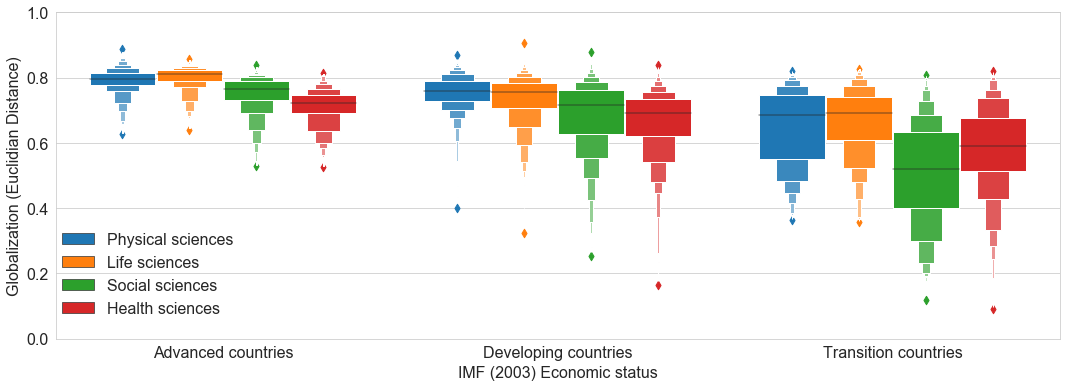

In [11]:
groups = glob.loc[idx[ccodes,flds_broad[:-1],'euclid',:]].reset_index()
groups['imf2003'] = groups.country_code.map(cntrs.imf2003)
groups['fields'] = groups.field_code.map(fieldnames)

plt.figure(figsize=(18,6))
sns.boxenplot(x='imf2003',
            y='value',
            hue='fields',
            hue_order=['Physical sciences','Life sciences','Social sciences','Health sciences'],
            order=['Advanced countries','Developing countries','Transition countries'],
            saturation=1,
            data=groups)
plt.legend(frameon=False,fontsize=16,loc=(0,0.05))
plt.ylim((0,1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Globalization (Euclidian Distance)',fontsize=16);
plt.xlabel('IMF (2003) Economic status',fontsize=16);
plt.savefig('figs/fig2.png')


In [12]:
groups = glob.loc[idx[ccodes,flds_broad,'euclid',:]].reset_index()
groups['eu'] = groups.country_code.map(cntrs.eu)
groups['name'] = groups.country_code.map(cntrs.name)
groups = groups[groups.eu == 'EU-28']
order = groups[(groups.field_code == 'All') & (groups.period == 2017)].sort_values(by='value').name

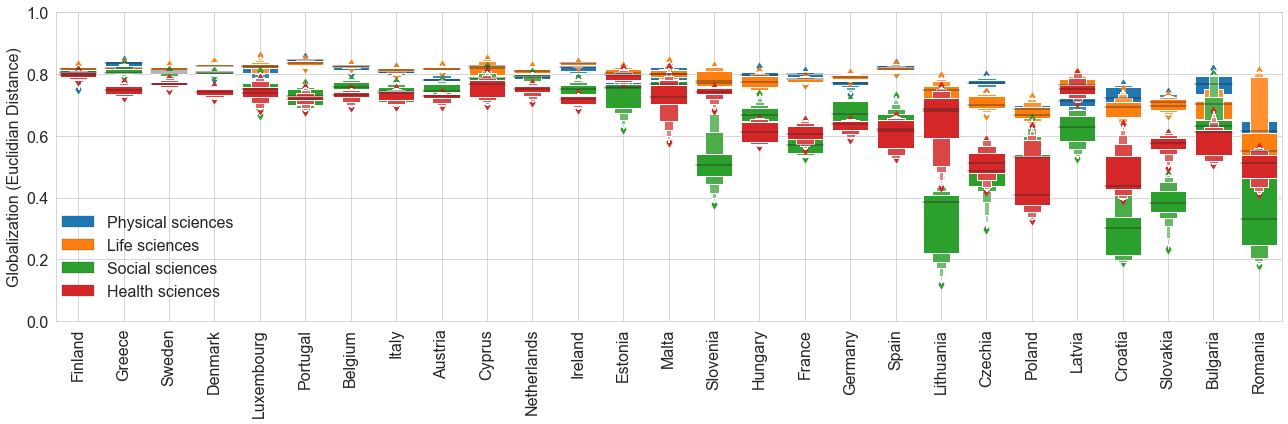

In [14]:
groups = glob.loc[idx[ccodes,flds_broad,'euclid',:]].reset_index()
groups['eu'] = groups.country_code.map(cntrs.eu)
groups['name'] = groups.country_code.map(cntrs.name)
groups = groups[groups.eu == 'EU-28']
groups = groups[groups.name != 'United Kingdom']

ranking = list(groups[(groups.field_code == 'All') & (groups.period == 2017)].sort_values(by='value',ascending=False).name)
groups = groups[groups.field_code != 'All']

groups['fields'] = groups.field_code.map(fieldnames)

plt.figure(figsize=(18,6))
sns.boxenplot(x='name',
            y='value',
            hue='fields',
            hue_order=['Physical sciences','Life sciences','Social sciences','Health sciences'],
            order=ranking,
            saturation=1,
            linewidth=0.5,
            dodge=False,
            data=groups)
plt.legend(frameon=False,fontsize=16,loc=(0.,0.05))
plt.ylim((0,1))
plt.xticks(fontsize=16,rotation=90)
plt.yticks(fontsize=16)
plt.grid(b=True,which='major',axis='x')
plt.ylabel('Globalization (Euclidian Distance)',fontsize=16);
plt.xlabel('',fontsize=16);
plt.tight_layout()
plt.savefig('figs/fig3.png')


## Full-Sample correlation


In [ ]:
corr_full = glob.unstack('method_code').corr()
corr_full.loc[usedIndicators,usedIndicators]

## China and Russia 

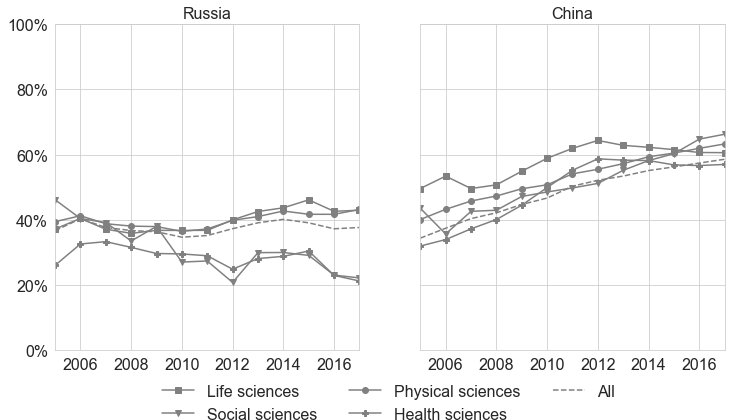

In [33]:
fig, axs = plt.subplots(1,2,sharey=True,figsize=(12,6))
l = ['RUS','CHN']
chnrus = glob.loc[idx[['CHN','RUS'],flds_broad,'euclid',:]].unstack('field_code').reset_index().drop('method_code',axis=1).set_index(['country_code','period'])

countrynames = {
    'RUS':'Russia','CHN':'China'
}
chnrus = chnrus.rename(fieldnames,axis=1)
lstyles = ['s-','v-','o-','P-','--']
for i in range(2):
    ax = axs[i]
    ax.set_ylim((0,1))
    ax.set_title(countrynames[l[i]],fontsize=16)
    chnrus.xs(l[i]).plot(ax=ax,style=lstyles,c='gray',fontsize=16,legend=None)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set_xlabel('')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',ncol=3,fontsize=16,bbox_to_anchor=(0.45, -0.038),frameon=False)
#plt.tight_layout(h_pad=2)
#plt.savefig('figs/fig5.png')


## Research output distribution in selected EU countries

In [34]:
import matplotlib.colors as mc
selected = ['Czech Republic','Slovakia','Poland','Bulgaria','France','Germany','Netherlands','Denmark','Austria','Portugal','Spain']
dists = pd.read_csv('../Phase2_CalcGlobalization/country_dists/country_dists_{}.csv'.format('euclid'),index_col=['Country','field','period']).drop('method',axis=1)
seldists = dists.loc[idx[selected,flds_broad[:-1],2017],['Q1','Q2','Q3','Q4']].reset_index().drop('period',axis=1).set_index(['Country','field']).rename(index=fieldnames)
fields = ['Physical sciences','Life sciences','Social sciences','Health sciences']
alphas = [1,0.75,0.5,0.25]
defcolors=[c['color'] for c in list(plt.rcParams['axes.prop_cycle'])]

import matplotlib.patches as mpatches

gray_patches = [mpatches.Patch(color=mc.to_rgba('#383838',alpha), label='Q{}'.format(i+1)) for i,alpha in enumerate(alphas)]

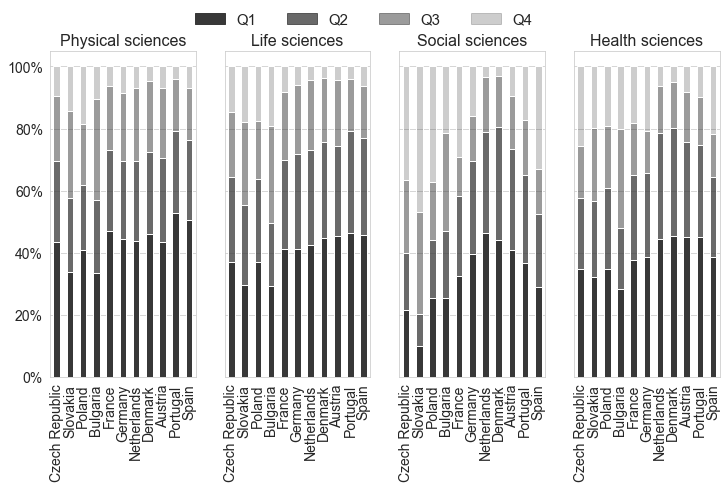

In [35]:
props = {c:{'base_color':'#383838'} for i,c in enumerate(selected)}
fig, axs = plt.subplots(ncols=len(fields),nrows=1,figsize=(12,6),sharex=True,sharey=True)
colors = [[mc.to_rgba(props[cntr]['base_color'],alpha) for cntr in props] for alpha in [1.0,.75,.5,.25]]

for i,fld in enumerate(fields):
    ax=axs[i]
    #breakpoint()
    subdf = seldists.loc[idx[:,fld],:].reset_index().set_index('Country').drop('field',axis=1).loc[selected]
    #breakpoint()
    subdf.plot.bar(
        stacked=True,
        ax=ax,
        color=colors,
        legend=None,
        fontsize=14)
    ax.set_title(fld,fontsize=16)
    ax.set_xlabel('')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.xaxis.grid(False)
fig.legend(handles=gray_patches,loc='upper center',ncol=4,frameon=False,fontsize=15);
pl

## Output CSVs as an appendix

In [ ]:
glob.to_csv('../public_data/globalization_scores.csv',header=True)
cntrs.imf2003.to_csv('../public_data/imf2003_classification.csv',header=True)
dists.to_csv('../public_data/globalization_quartiles.csv')

## Appendix A4: IMF (2003) country classification 

In [ ]:
for group in ['Advanced countries','Developing countries','Transition countries']:
    l = list(cntrs[cntrs.imf2003 == group].name)
    l.sort()
    print('{}: '.format(group) + ', '.join(l) + '\n')

### EnglishDocuments footnote

In [ ]:
sns.violinplot(x='method_code',y='value',data=glob.to_frame().reset_index(),figsize=(20,6))